# Walkthrough of 2D Erosion Implementation
In this notebook we give a runthrough of our porous media erosion model, assuming pressure equilibrates with time. 

In [1]:
# imports
import numpy as np 
import matplotlib.pyplot as plt
import sys
from math import sin, cos, pi, tanh
from random import seed
from numpy.random import random
from numpy import exp

## Generating a Smoothed Porous Media
We create a smoothed media fraction using gaussian smoothing convolving each point across a square grid with communication length epsilon

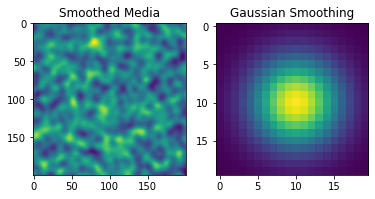

In [2]:
from utils_2D import convolve_matrix, w_matrix 
eps = 0.05; res = 200 # eps gives communication length, res is resolution
dim = int(np.ceil(res*(1+2*eps))) # expand range to get good communication length
phi_rand = random((dim, dim))

# apply smoothing
smoothed = convolve_matrix(phi_rand, eps, res)
fig, ax = plt.subplots(1,2)
ax[0].imshow(smoothed)
ax[0].set_title("Smoothed Media")
ax[1].imshow(w_matrix(eps, res))
ax[1].set_title("Gaussian Smoothing");

## Updating Fluid Flux
Now that we have our media, we set out to implement erosion by computing an update rule for both the density field and subsequently the media. We use two helper functions $q_x$ and $q_y$ to calculate the flux across the vertical and horizontal walls of a gridcell, ultimately combining these to get a total density flux into a gridcell. A third helper function $\Kappa(\phi)$ takes the average media across the two grid cells to determine how easy it is to flow between them.

In [3]:
# We change to a 20x20 grid for debugging below
eps = 0.3; res = 20 # eps gives communication length, res is resolution
dim = int(np.ceil(res*(1+2*eps))) # expand range to get good communication length
phi_rand = random((dim, dim))

# apply smoothing
smoothed = convolve_matrix(phi_rand, eps, res)

Text(0.5, 1.0, 'rho 1')

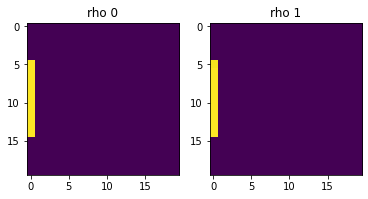

In [4]:
# Functions for this section
from utils_2D import Kappa, q_x, q_y, update_rho, rho_np1

# initialize a rho0 with some initial fluid pressure
rho0 = np.zeros((res,res))
rho0[5:15,0] = np.ones(10)/2

# Update rho
rho1 = rho_np1(smoothed, rho0, dim, dt=0.5, c=0.1**2)
# display differences
fig, ax = plt.subplots(1,2)
ax[0].imshow(rho0, vmin=0, vmax=.5)
ax[1].imshow(rho1, vmin=0, vmax=.5)
ax[0].set_title("rho 0")
ax[1].set_title("rho 1")

### Discussion
We see that while there is some updating from $\rho_0$ to $\rho_1$ there is essentially no fluid flux to neighboring cells (it's very faint - e.g. e-6). We've played around with $c$ but while higher values of $c$ make the fluid move, the values blow up. 

## Updating Phi
We use the newly computed fluid density to update the solid fraction by comparing the fluid density a transformation of $\phi$ - e.g. $\psi(\phi)$ is a measure of the resisitivity to erosion and is sensitive around some breaking point $\phi^*=0.4$ chosen somewhat arbitrarily. 
To update $\phi$ we use forward Euler where the derivative $\frac{\partial phi}{\partial t}$ is the updated fluid fraction minus $\psi(\phi)$.

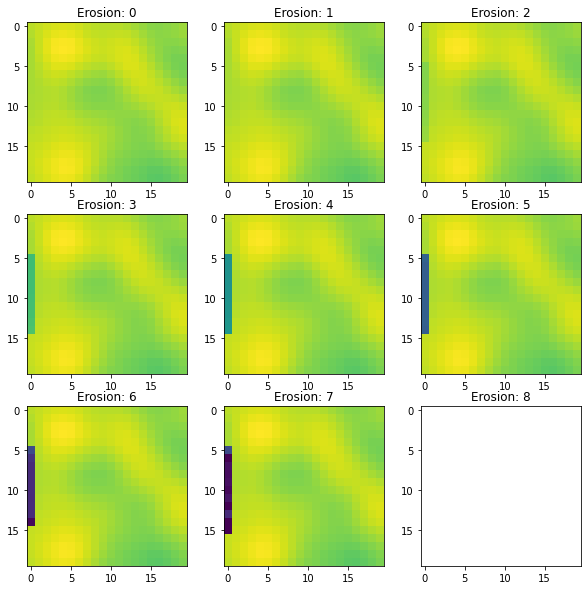

In [12]:
from utils_2D import psi, update_phi

# we can then take time steps as follows
rhos = [rho0]; phis = [smoothed]
for i in range(10):
    # update rho
    rhos.append(rho_np1(phis[i], rhos[i]+rho0, dim))
    # update phi
    phis.append(update_phi(phis[i], rhos[i+1], dt=0.05))


# display plot of solid fraction - some erosion initially, then bugs
fig, ax = plt.subplots(3,3, figsize=((10,10)))

axs = ax.ravel()

for i in range(9):
    axs[i].imshow(phis[i], vmin=0, vmax = 1)
    axs[i].set_title(f"Erosion: {i}")

### Discussion
We see that while erosion does progress with time - it seems like the time step is reasonable, the fluid is unable to propagate and the whole model breaks after 9 steps. We suspect there are additional constants that may have to be tuned or there are methodological errors in our implementation.